# Lab:  Logistic Regression for Gene Expression Data

In this lab, we use logistic regression to predict biological characteristics ("phenotypes") from gene expression data.  In addition to the concepts in the demo for this unit, you will learn to:
* Handle missing data
* Perform multi-class logistic classification
* Create a confusion matrix
* Use L1-regularization for improved estimation in the case of sparse weights

## Background

Genes are the basic unit in the DNA and encode blueprints for proteins.  When proteins are synthesized from a gene, the gene is said to "express".  Micro-arrays are devices that measure the expression levels of large numbers of genes in parallel.  By finding correlations between expression levels and phenotypes, scientists can identify possible genetic markers for biological characteristics.

The data in this lab comes from:

https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression

In this data, mice were characterized by three properties:
* Whether they had down's syndrome (trisomy) or not
* Whether they were stimulated to learn or not
* Whether they had a drug memantine or a saline control solution.

With these three choices, there are 8 possible classes for each mouse.  For each mouse, the expression levels were measured across 77 genes.  We will see if the characteristics can be predicted from the gene expression levels.  This classification could reveal which genes are potentially involved in Down's syndrome and if drugs and stimulation have any noticeable effects.


## Load the Data

We begin by loading the standard modules.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

Use the `pd.read_excel` command to read the data from 

https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls

into a dataframe `df`.  Use the `index_col` option to specify that column 0 is the index.  Use the `df.head()` to print the first few rows.

In [2]:
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls',index_col=0)
df.head(5)

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
MouseID,,,,,,,,,,,,,,,,,,,,,
309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m


This data has missing values.  The site:

http://pandas.pydata.org/pandas-docs/stable/missing_data.html

has an excellent summary of methods to deal with missing values.  Following the techniques there, create a new data frame `df1` where the missing values in each column are filled with the mean values from the non-missing values.

In [3]:
df1 = df
NaN_df = df.loc[:,df.isna().any()] #get the columns which has missing data
for c_NaN in NaN_df.columns:
    df1[c_NaN] = df1[c_NaN].fillna(df1[c_NaN].mean())
nan_df1 = df.loc[:,df1.isnull().any()]
print(nan_df1)

Empty DataFrame
Columns: []
Index: [309_1, 309_2, 309_3, 309_4, 309_5, 309_6, 309_7, 309_8, 309_9, 309_10, 309_11, 309_12, 309_13, 309_14, 309_15, 311_1, 311_2, 311_3, 311_4, 311_5, 311_6, 311_7, 311_8, 311_9, 311_10, 311_11, 311_12, 311_13, 311_14, 311_15, 320_1, 320_2, 320_3, 320_4, 320_5, 320_6, 320_7, 320_8, 320_9, 320_10, 320_11, 320_12, 320_13, 320_14, 320_15, 321_1, 321_2, 321_3, 321_4, 321_5, 321_6, 321_7, 321_8, 321_9, 321_10, 321_11, 321_12, 321_13, 321_14, 321_15, 322_1, 322_2, 322_3, 322_4, 322_5, 322_6, 322_7, 322_8, 322_9, 322_10, 322_11, 322_12, 322_13, 322_14, 322_15, 3415_1, 3415_2, 3415_3, 3415_4, 3415_5, 3415_6, 3415_7, 3415_8, 3415_9, 3415_10, 3415_11, 3415_12, 3415_13, 3415_14, 3415_15, 3499_1, 3499_2, 3499_3, 3499_4, 3499_5, 3499_6, 3499_7, 3499_8, 3499_9, 3499_10, ...]

[1080 rows x 0 columns]


## Binary Classification for Down's Syndrome

We will first predict the binary class label in `df1['Genotype']` which indicates if the mouse has Down's syndrome or not.  Get the string values in `df1['Genotype'].values` and convert this to a numeric vector `y` with 0 or 1.  You may wish to use the `np.unique` command with the `return_inverse=True` option.

In [4]:
# TODO
# y = ...
ind,y = np.unique(df1['Genotype'].values,return_inverse=True)
print(y)

[0 0 0 ... 1 1 1]


As features, get all but the last four columns of the dataframes.  Standardize the data matrix and call the standardized matrix `Xs`.  The features are the expression levels of the 77 genes.  Also, store the number of samples in the dataset in the variable `nsamp`.

In [5]:
# TODO
# Xs = ...
# nsamp = ...
from sklearn.preprocessing import StandardScaler
r,c = df1.shape
select_cols=df.columns[0:c-4]
X = df1[select_cols]
Xs = preprocessing.scale(X)
nsamp = r
print(nsamp)
print(Xs)

1080
[[ 0.31271112  0.5179336   2.2536689  ... -1.41662394 -1.60789061
   1.06590091]
 [ 0.35679793  0.28650133  1.8802795  ... -1.32521803 -1.54684392
   1.28029118]
 [ 0.33496588  0.45046461  2.01292763 ... -1.37325709 -1.62359464
   1.85703831]
 ...
 [-0.79192771 -0.88354273 -1.72382963 ...  1.27078193  3.11724261
   0.29352469]
 [-0.82188815 -0.8130138  -1.52387571 ...  1.88117889  3.32828966
   0.2089962 ]
 [-0.49491588 -0.62125474 -1.26845332 ...  1.92748438  3.32672533
   0.10478825]]


Create a `LogisticRegression` object `logreg` and `fit` the training data. Use C = 1e5 and the 'liblinear' solver.

In [6]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C= 1e5,solver='liblinear')
logreg.fit(Xs,y)

LogisticRegression(C=100000.0, solver='liblinear')

Measure the training accuracy of the classifer.  That is, use the `logreg.predict` function to predict labels `yhat` and measure the fraction of cases that the predictions match the true labels.  

In [7]:
yhat = logreg.predict(Xs)
acc = np.mean(yhat == y)
print(acc)

1.0


Don't get too excited if you achieved perfect accuracy on the training data. Later, we will properly evaluate the accuracy using cross-validation.

## Interpreting the weight vector

Create a stem plot of the coefficients, `W`, in the logistic regression model using `plt.stem`.  You can get the coefficients from `logreg.coef_`, but you will need to reshape this to a 1D array.  

<StemContainer object of 3 artists>

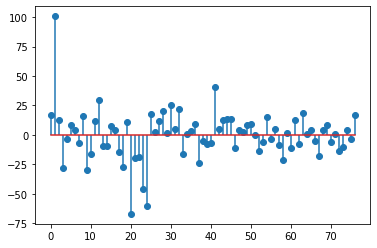

In [8]:
# TODO
# W =
# plt.stem(W)
w = logreg.coef_
W = w.reshape(c-4,1)
x = np.arange(0,c-4,1)
plt.stem(x,W)


You should see that `W[j]` is very large for a few components `j`.  These may be the genes that are most predictive of Down's Syndrome.  Later, using L1 regularization, we will obtain a sparse weight vector.  

Find the names of the genes for two components `j` where the magnitude of `W[j]` is largest.  

In [9]:
import heapq
max1=heapq.nlargest(2,abs(W))
print(max1)
t1=max1[0]
t2=max1[1]
max_index1=np.argwhere(W==t1)
max_index2=np.argwhere(W==-t2)
index1=max_index1.flatten()
index2=max_index2.flatten()
Index1=index1[0]
print(Index1)
Index2=index2[0]
print(Index2)
name1 = df1.columns[Index1]
name2 = df1.columns[Index2]
print(name1,name2)

[array([100.70495104]), array([67.01390379])]
1
20
ITSN1_N BRAF_N


## Cross Validation

Training accuracy can be misleading because it will not show the effects of overfitting.  The correct approach is to measure accuracy using cross-validation.  

For the same `LogisticRegression` classifier, perform 10-fold cross-validation and measure the average precision, recall, f1-score, and accuracy.  Note that in performing the cross-validation, you will want to randomly permute the test and training sets using the `shuffle` option.  In this data set, all the samples from each class are bunched together, so shuffling is very important!  Compute and print the mean precision, recall, f1-score, and accuracy averaged across the folds.  Also compute and print the standard errors on these quantities.

Because the shuffling is random, you will get different results every time you run this notebook.  If you'd like to avoid those variations, you can set the `random_state` parameter in `KFold` to a fixed integer.  When you've completed the lab, you could try changing the value of that integer to see how the results change.

In [10]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
# TODO
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True,random_state = 42)
scores = ('precision','recall','f1','accuracy')
cv_results = cross_validate(logreg,Xs,y,cv=kf,scoring=scores)

prec = cv_results['test_precision']
rec = cv_results['test_recall']
f1 = cv_results['test_f1']
acc = cv_results['test_accuracy']

precm = np.mean(prec)
recm = np.mean(rec)
f1m = np.mean(f1)
accm = np.mean(acc)

prec_se = np.std(prec,ddof=1)/np.sqrt(nfold)
rec_se = np.std(rec,ddof=1)/np.sqrt(nfold)
f1_se = np.std(f1,ddof=1)/np.sqrt(nfold)
acc_se = np.std(acc,ddof=1)/np.sqrt(nfold)

print('Precision = {0:.4f}, SE={1:.4f}'.format(precm,prec_se))
print('Recall =    {0:.4f}, SE={1:.4f}'.format(recm,rec_se))
print('F1 =        {0:.4f}, SE={1:.4f}'.format(f1m,f1_se))
print('Accuracy =  {0:.4f}, SE={1:.4f}'.format(accm,acc_se))

Precision = 0.9436, SE=0.0069
Recall =    0.9562, SE=0.0075
F1 =        0.9495, SE=0.0033
Accuracy =  0.9519, SE=0.0039


## Multi-Class Classification

Now set the target to `df1['class']`.  This target has 8 categories.  Use the `np.unique` funtion as before to convert it to a vector `y` with values from 0 to 7.

In [11]:
# TODO
# y = 

ind,y = np.unique(df1['class'].values,return_inverse=True)
print(y)

[0 0 0 ... 7 7 7]


The next task is to fit a multi-class logistic model by instantiating a `LogisticRegression` object as `logreg` and then calling the `logreg.fit` method. 

In general, you could set the `multi_class` option as either 'one-versus-rest/all (ovr)' or 'multinomial'.  The 'multinomial' option is what we discussed in the lecture as _multinomial logistic regression_.  Meanwhile, 'ovr' trains a separate one-versus-rest classifier for each class using _binary_ logistic regression, and then chooses the class yielding the highest score.  Usually 'multinomial' option works better than 'ovr', but it is takes longer to fit the coefficients.  To save time, we will use the 'ovr' option in this lab, but feel free to try the 'multinomial' option later if you want.  Note that, for 'multinomial', you will have fewer choices of optimizer and you may need to increase the `max_iter` parameter from the default value.

In this lab, use `multi_class='ovr'`, the `solver='liblinear'` solver, and `C=1`.

In [12]:
# TODO
# logreg = 
logreg = LogisticRegression(multi_class='ovr',solver='liblinear',C=1)
logreg.fit(Xs,y)

LogisticRegression(C=1, multi_class='ovr', solver='liblinear')

Extract the coefficient matrix from the trained model.  It should be of size 8 x 77.  Create a stem plot of the first row of this matrix to see the weight applied to each of the 77 genes.

(8, 77)


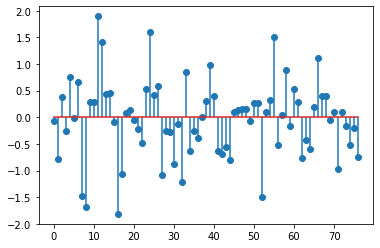

In [13]:
# TODO
# W = 
# plt.stem...
W = logreg.coef_
w = W[0].reshape(c-4,1)
x = np.arange(0,c-4,1)
plt.stem(x,w)
print(W.shape)

Now perform 10-fold cross validation and compute/plot the confusion matrix `C` on the test data across folds.
To do this, you'll first want to use sklearn's `cross_val_predict` to output predictions `yhat` of all the samples `y`.
Second, use sklearn's `confusion_matrix` method to turn those predictions into a confusion matrix, using the `normalize='true'` option to make the rows sum to one. 
Third, plot the confusion matrix using sklearn's `ConfusionMatrixDisplay`.
Finally, print the overall mean and SE of the test accuracy estimated from your 10-fold predictions.

Be careful when computing the SE from the `yhat` predictions: you will be averaging `nsamp` error values, not `nfold` error values.

[0 0 0 ... 7 7 7] 0.9870370370370368 0.0004028580289599018


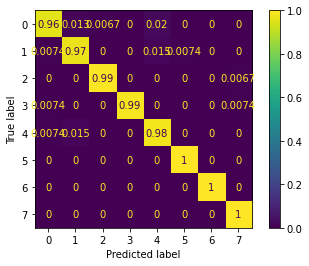

In [14]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# TODO
# yhat =
# C = 
# acc_mean = 
# acc_se = 

nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)
yhat = cross_val_predict(logreg, Xs, y, cv=kf)
C = confusion_matrix(y,yhat,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=C)
disp.plot();

scores = ('accuracy')
cv_results = cross_validate(logreg,Xs,y,cv=kf,scoring=scores)

acc = cv_results['test_score']
acc_mean = np.mean(acc)
acc_se = np.std(acc,ddof=1)/np.sqrt(nsamp)
print(yhat,acc_mean,acc_se)

## L1 regularization tuned with GridSearchCV and a pipeline

In most genetics datasets, only a few genes influence any particular attribute.  Hence, we know apriori that the weight coefficients should be sparse.  That is, many coefficents should be zero in the weight vector that predicts a given attribute.  In genetics, weight-sparsity is commonly implemented by incorporating an L1-penalty term in logistic regression.  The `sklearn` [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) describes how L1-regularization can be selected in `LogisticRegression` and how the inverse regularization strength, `C`, can be selected.

As we know, the use of L1-regularization will zero a subset of the trained weights (which is what we want), but it will bias the remainder of the weights towards zero (which is not what we want).  To avoid that bias, we can extract the *indices* of the non-zero weights and fit an *unregularized* logistic regression model using the features selected by those indices.  When tuning the L1-regularization strength, it is the performance of the final unregularized coefficients that matter, not the intermediate L1-regularized coefficients.  We can use sklearn's `GridSearchCV` method to do this tuning if we create a `Pipeline` for this two-stage approach of (L1 guided) feature selection followed by logistic regression.

Using the pipeline-based GridSearchCV procedure described in the demo, select an appropriate inverse regularization strength using K-fold cross validation:
* Use the 10-fold cross-validation object created earlier with `accuracy` as the metric
* Select around 20 logarithmically spaced values of `C`.  It is up to you find a good range.

Don't worry too much about warnings that say to increase the number of iterations.

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
pipe = Pipeline([
  ('featsel',SelectFromModel(LogisticRegression(penalty='l1',solver='liblinear',warm_start=True))),
  ('logreg', LogisticRegression(C=1e5))
])
kf=10
npen = 20
C_lasso = np.logspace(-2,6,npen) 
parameters = {'featsel__estimator__C':C_lasso} 
gscv = GridSearchCV(pipe, parameters, cv=kf, scoring='accuracy')
gscv.fit(Xs,y);

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Now compute the mean and standard error on the error rate (i.e., 1 minus the accuracy) for each `C` and plot the results (using the `plt.errorbar` method). Identify the minimizing `C` value using a vertical dashed line on the plot.  Finally, print the maximum accuracy and it's standard error.

The minimum test error rate =   1.4722e-01, SE=  2.3320e-02
The C value corresponding to minimum error =   1.8330e-01
Best CV accuracy = 0.8527777777777776
Best parameters = {'featsel__estimator__C': 0.18329807108324356}
Numerical value of best C parameter = 0.18329807108324356


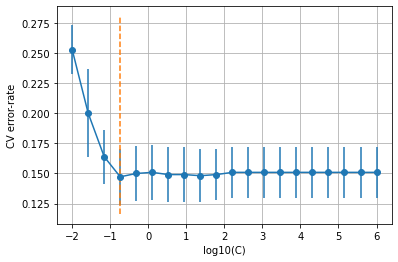

In [16]:
C_best = gscv.best_estimator_.named_steps["featsel"].estimator.C
err_mean = 1-gscv.cv_results_['mean_test_score'] 
err_se = gscv.cv_results_['std_test_score']/np.sqrt(nfold-1)
imin = np.argmin(err_mean)
C_min = C_lasso[imin] 

plt.errorbar(np.log10(C_lasso), err_mean, marker='o',yerr=err_se)
xmin, xmax, ymin, ymax = plt.axis()
plt.plot(np.log10([C_min,C_min]),[ymin,ymax],'--')

plt.grid()
plt.xlabel('log10(C)')
plt.ylabel('CV error-rate')

print("The minimum test error rate = %12.4e, SE=%12.4e" % (err_mean[imin], err_se[imin]))
print("The C value corresponding to minimum error = %12.4e" % C_min)
print("Best CV accuracy = "+str(gscv.best_score_))
print("Best parameters = "+str(gscv.best_params_))
print("Numerical value of best C parameter = "+str(C_best))

You should see an accuracy better than that of the previous classifier, which did not use feature selection. 

For the CV-optimized design, extract the weight matrix of L1-regularized logistic regression (i.e., the first stage of the pipeline) and store it in `W_l1`.  Also create an all-zeros matrix `W_pipe` with same the dimensions as `W_l1`, and store within it the weights of feature-selected logistic-regression (i.e., the second stage of the pipeline). 

Plot the first row of the coefficient matrix `W` created earlier in this lab, which corresponds to unregularized logistic regularization applied to all features.
To the right of it, plot the first row of `W_l1`, and to the right of it plot the first row of `W_pipe`.

Also print out the total number of coefficients and the number of coefficients selected.

(8, 70)
(8, 77)
(8, 77)


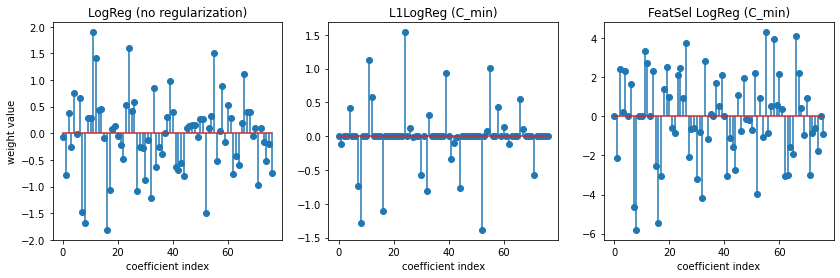

In [17]:
pipe_best = gscv.best_estimator_ 

W_l1 = pipe_best.named_steps["featsel"].estimator_.coef_
support = pipe_best.named_steps["featsel"].get_support()
W_pipe = np.zeros(W_l1.shape)
W_pipe[:,support] = pipe_best.named_steps["logreg"].coef_

print(pipe_best.named_steps["logreg"].coef_.shape)
print(W_pipe.shape)
print(W_l1.shape)
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.stem(W[0])

plt.title('LogReg (no regularization)')
plt.ylabel('weight value')
plt.xlabel('coefficient index')
plt.subplot(1,3,2)
plt.stem(W_l1[0])
plt.title('L1LogReg (C_min)')
plt.xlabel('coefficient index')
plt.subplot(1,3,3)
plt.stem(W_pipe[0])

plt.title('FeatSel LogReg (C_min)')
plt.xlabel('coefficient index');

The L1-regularized weight vector `W_l1[0,:]` should be much more sparse than the unregularized non-feature-selected weight vector `W[0,:]`, making the roles of particular genes much more clearly visible. 
You should also see that the weights of `W_pipe[0,:]` are sparse, but not nearly as sparse as `W_l1[0,:]`.  This is because the pipeline's feature-selection stage chooses *a single set of features to use for all K prediction vectors*, whereas L1-regularized logistic regression can use a different set of features for each prediction vector in a K>2-class classification problem.

## L1 regularization tuned with GridSearchCV and the one-standard-error rule

If we want to allow each predictor to use a different set of features for each predictor in a K>2-class classification problem, we can't use the pipeline method above.
Instead, we could use a simpler method: just train L1-regularized logistic regression and use its weights as-is, even though they are biased. 
To tune the regularization strength `C`, we can use GridsearchCV, or we can go one step further and use the one-standard-error rule in an attempt to reduce overfitting and make the predictors even more sparse.
Below, we'll do the latter.

First instantiate an L1-regularized logistic regression object using the `liblinear` solver, `ovr`, and `warm_start=True`. 
Next create an appropriate grid of `C` values. 
Then run grid-search cross-validation over that grid with the K-fold object created earlier and the `accuracy` metric.

In [18]:
lasso = LogisticRegression(penalty='l1', solver='liblinear', warm_start=True)

npen = 20
C_lasso = np.logspace(-2,6,npen)

parameters = {'C':C_lasso}
clf = GridSearchCV(lasso, parameters, cv=kf, scoring='accuracy')
clf.fit(Xs,y)


GridSearchCV(cv=10,
             estimator=LogisticRegression(penalty='l1', solver='liblinear',
                                          warm_start=True),
             param_grid={'C': array([1.00000000e-02, 2.63665090e-02, 6.95192796e-02, 1.83298071e-01,
       4.83293024e-01, 1.27427499e+00, 3.35981829e+00, 8.85866790e+00,
       2.33572147e+01, 6.15848211e+01, 1.62377674e+02, 4.28133240e+02,
       1.12883789e+03, 2.97635144e+03, 7.84759970e+03, 2.06913808e+04,
       5.45559478e+04, 1.43844989e+05, 3.79269019e+05, 1.00000000e+06])},
             scoring='accuracy')

Now compute the mean and standard-error on the error rate (i.e., 1-accuracy) for each `C` and plot the results using the `plt.errorbar` method. 
Identify the minimizing value of `C` and plot it using a vertical dashed line. 
Finally, print the maximum accuracy and its standard error.

The minimum test error rate =   1.2593e-01, SE=  2.3310e-02
The C value corresponding to minimum error =   8.8587e+00


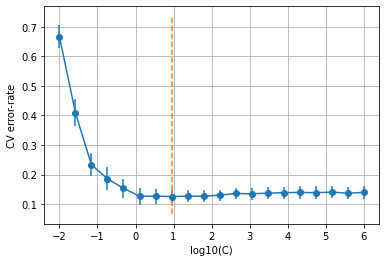

In [19]:
err_mean = 1-clf.cv_results_['mean_test_score'] 
err_se = clf.cv_results_['std_test_score']/np.sqrt(nfold-1)
imin = np.argmin(err_mean)
C_min = C_lasso[imin]
plt.errorbar(np.log10(C_lasso), err_mean, marker='o',yerr=err_se)
xmin, xmax, ymin, ymax = plt.axis()

plt.plot(np.log10([C_min,C_min]),[ymin,ymax],'--')
plt.grid()
plt.xlabel('log10(C)')
plt.ylabel('CV error-rate')

print("The minimum test error rate = %12.4e, SE=%12.4e" % (err_mean[imin], err_se[imin]))
print("The C value corresponding to minimum error = %12.4e" % C_min)


You should see that the accuracy is better than that of the classifier that did not use the L1-penalty.  

Next, use the one-standard error rule to determine `C` and make a plot of the error-rate versus `C` (using the `plt.errorbar` method) that also shows the target error rate and the one-standard-error value of `C`. 

One-standard-error-rule C=  1.2743e+00
The OSE test-error rate =   1.2685e-01, SE=  2.9412e-02
The OSE accuracy =  0.8731, SE=0.0294


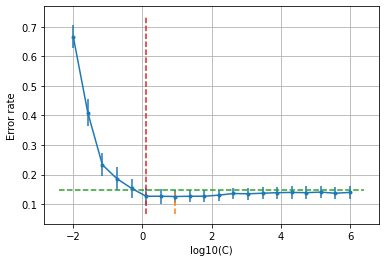

In [20]:
err_tgt = err_mean[imin] + err_se[imin]
iose = np.where(err_mean < err_tgt)[0][0]
C_ose = C_lasso[iose]

plt.errorbar(np.log10(C_lasso), err_mean, marker='.',yerr=err_se)
xmin, xmax, ymin, ymax = plt.axis()
plt.plot(np.log10([C_min,C_min]),[ymin,err_tgt],'--')
plt.plot([xmin,xmax],[err_tgt,err_tgt],'--')
plt.plot(np.log10([C_ose,C_ose]),[ymin,ymax],'--')
plt.grid()
plt.xlabel('log10(C)')
plt.ylabel('Error rate')

print("One-standard-error-rule C=%12.4e" % C_ose)
print("The OSE test-error rate = %12.4e, SE=%12.4e" % (err_mean[iose], err_se[iose]))
print('The OSE accuracy =  {0:.4f}, SE={1:.4f}'.format(1-err_mean[iose], err_se[iose]))


For the one-standard-error `C`, fit the L1-regularized model on the entire training data and extract the resulting weight matrix, `W_ose`.  Plot the first row of this weight matrix and compare it to the first row of the weight matrix fit with L2 regularization.  You should see that, with L1-regularization, the weight matrix is much more sparse and hence the roles of particular genes are more clearly visible. 

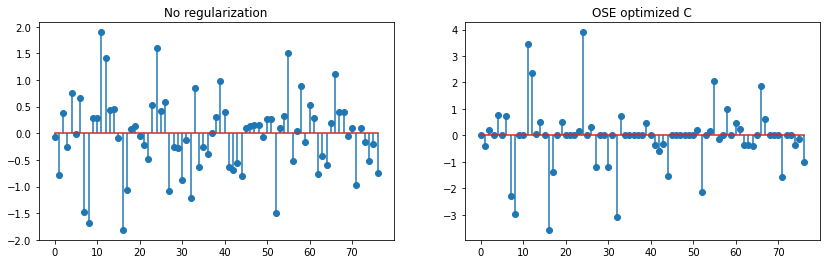

In [21]:
# TODO
lasso = LogisticRegression(C=C_ose,penalty='l1',solver='liblinear')
lasso.fit(Xs,y)
W_ose = lasso.coef_
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.stem(x,W[0])
plt.title('No regularization')
plt.subplot(1,2,2)
plt.stem(x,W_ose[0])
plt.title('OSE optimized C') 
subset = np.where(np.abs(W_ose)>0)[0]

Finally, use 10-fold cross-validation to evaluate the accuracy of LASSO with the one-standard-error `C`. 

In [22]:
# TODO
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)
scores = ('accuracy')
cv_results = cross_validate(logreg,Xs,y,cv=kf,scoring=scores)
acc = cv_results['test_score']
accm = np.mean(acc)
print(accm)

0.9842592592592594


Although the accuracy is not very high, the weights are much more sparse. 